# __Astro Entity Classifier - Galaxy, Star, or Quasar__

## _Problem Statement:_
> In astronomy, stellar classification is the classification of stars based on their spectral characteristics. The classification scheme of galaxies, quasars, and stars is <br> one of the most fundamental in astronomy. The early cataloguing of stars and their distribution in the sky has led to the understanding that they make up our own galaxy and, following the distinction that Andromeda was a separate galaxy to our own, numerous galaxies began to be surveyed as more powerful teles- <br> copes were built. Create an ML model that classificates stars, galaxies, & quasars based on their celestial coordinates (right ascension, declination) and spectral characteristics such as color indices and redshift.

## __Importing Necessary Libraries__

In [1]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_predict
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scienceplots
from joblib import dump

plt.style.use(["science","notebook","grid"])

## __Step-1: Loading the Dataset__

The data consists of 100,000 observations of space taken by the SDSS (Sloan Digital Sky Survey). Every observation is described by 17 feature columns and 1 class column which identifies it to be either a star, galaxy or quasar.

* obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
* alpha = Right Ascension angle (at J2000 epoch)
* delta = Declination angle (at J2000 epoch)
* u = Ultraviolet filter in the photometric system
* g = Green filter in the photometric system
* r = Red filter in the photometric system
* i = Near Infrared filter in the photometric system
* z = Infrared filter in the photometric system
* run_ID = Run Number used to identify the specific scan
* rereun_ID = Rerun Number to specify how the image was processed
* cam_col = Camera column to identify the scanline within the run
* field_ID = Field number to identify each field
* spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same * * spec_obj_ID must share the output class)
* class = object class (galaxy, star or quasar object)
* redshift = redshift value based on the increase in wavelength
* plate = plate ID, identifies each plate in SDSS
* MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
* fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

Retrived from [__SDSS17 via kaggle__](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17/data)

In [2]:
spectral_raw = pd.read_csv("SDSS_DR17.csv")
spectral_raw

obj_ID       alpha      delta         u         g         r  \
0      1.237660e+18  135.689107  32.494632  23.87882  22.27530  20.39501   
1      1.237660e+18  144.826101  31.274185  24.77759  22.83188  22.58444   
2      1.237660e+18  142.188790  35.582444  25.26307  22.66389  20.60976   
3      1.237660e+18  338.741038  -0.402828  22.13682  23.77656  21.61162   
4      1.237680e+18  345.282593  21.183866  19.43718  17.58028  16.49747   
...             ...         ...        ...       ...       ...       ...   
99995  1.237680e+18   39.620709  -2.594074  22.16759  22.97586  21.90404   
99996  1.237680e+18   29.493819  19.798874  22.69118  22.38628  20.45003   
99997  1.237670e+18  224.587407  15.700707  21.16916  19.26997  18.20428   
99998  1.237660e+18  212.268621  46.660365  25.35039  21.63757  19.91386   
99999  1.237660e+18  196.896053  49.464643  22.62171  21.79745  20.60115   

              i         z  run_ID  rerun_ID  ...  Unnamed: 24  Unnamed: 25  \
0      19.16573  18.79371    3606       301  ...          NaN          NaN   
1      21.16812  21.61427    4518       301  ...          NaN          NaN   
2      19.34857  18.94827    3606       301  ...          NaN          NaN   
3      20.50454  19.25010    4192       301  ...          NaN          NaN   
4      15.97711  15.54461    8102       301  ...          NaN          NaN   
...         ...       ...     ...       ...  ...          ...          ...   
99995  21.30548  20.73569    7778       301  ...          NaN          NaN   
99996  19.75759  19.41526    7917       301  ...          NaN          NaN   
99997  17.69034  17.35221    5314       301  ...          NaN          NaN   
99998  19.07254  18.62482    3650       301  ...          NaN          NaN   
99999  20.00959  19.28075    3650       301  ...          NaN          NaN   

       Unnamed: 26 Unnamed: 27  Unnamed: 28  Unnamed: 29  Unnamed: 30  \
0              NaN         NaN          NaN          NaN          NaN   
1              NaN         NaN          NaN          NaN          NaN   
2              NaN         NaN          NaN          NaN          NaN   
3              NaN         NaN          NaN          NaN          NaN   
4              NaN         NaN          NaN          NaN          NaN   
...            ...         ...          ...          ...          ...   
99995          NaN         NaN          NaN          NaN          NaN   
99996          NaN         NaN          NaN          NaN          NaN   
99997          NaN         NaN          NaN          NaN          NaN   
99998          NaN         NaN          NaN          NaN          NaN   
99999          NaN         NaN          NaN          NaN          NaN   

       Unnamed: 31  Unnamed: 32  Unnamed: 33  
0              NaN          NaN          NaN  
1              NaN          NaN          NaN  
2              NaN          NaN          NaN  
3              NaN          NaN          NaN  
4              NaN          NaN          NaN  
...            ...          ...          ...  
99995          NaN          NaN          NaN  
99996          NaN          NaN          NaN  
99997          NaN          NaN          NaN  
99998          NaN          NaN          NaN  
99999          NaN          NaN          NaN  

[100000 rows x 34 columns]

## __Step-2: Making the Dataset Preprocessable__

In [3]:
"""  
Creating a new dataset that contains desired features only with no duplicates
"""
print(spectral_raw.columns)
spectral = pd.DataFrame({"alpha":spectral_raw["alpha"], "delta":spectral_raw["delta"], "u":spectral_raw["u"], 
                        "g":spectral_raw["g"], "r":spectral_raw["r"], "i":spectral_raw["i"], "z":spectral_raw["z"],
                         "redshift":spectral_raw["redshift"], "class":spectral_raw["class"]})
spectral.drop_duplicates(inplace=True, ignore_index=True)
spectral

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift',
       'plate', 'MJD', 'fiber_ID', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24',
       'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28',
       'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32',
       'Unnamed: 33'],
      dtype='object')


alpha      delta         u         g         r         i  \
0      135.689107  32.494632  23.87882  22.27530  20.39501  19.16573   
1      144.826101  31.274185  24.77759  22.83188  22.58444  21.16812   
2      142.188790  35.582444  25.26307  22.66389  20.60976  19.34857   
3      338.741038  -0.402828  22.13682  23.77656  21.61162  20.50454   
4      345.282593  21.183866  19.43718  17.58028  16.49747  15.97711   
...           ...        ...       ...       ...       ...       ...   
99995   39.620709  -2.594074  22.16759  22.97586  21.90404  21.30548   
99996   29.493819  19.798874  22.69118  22.38628  20.45003  19.75759   
99997  224.587407  15.700707  21.16916  19.26997  18.20428  17.69034   
99998  212.268621  46.660365  25.35039  21.63757  19.91386  19.07254   
99999  196.896053  49.464643  22.62171  21.79745  20.60115  20.00959   

              z  redshift   class  
0      18.79371  0.634794  GALAXY  
1      21.61427  0.779136  GALAXY  
2      18.94827  0.644195  GALAXY  
3      19.25010  0.932346  GALAXY  
4      15.54461  0.116123  GALAXY  
...         ...       ...     ...  
99995  20.73569  0.000000  GALAXY  
99996  19.41526  0.404895  GALAXY  
99997  17.35221  0.143366  GALAXY  
99998  18.62482  0.455040  GALAXY  
99999  19.28075  0.542944  GALAXY  

[100000 rows x 9 columns]

In [4]:
spectral.describe(include="all")

alpha          delta              u              g  \
count   100000.000000  100000.000000  100000.000000  100000.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean       177.629117      24.135305      21.980468      20.531387   
std         96.502241      19.644665      31.769291      31.750292   
min          0.005528     -18.785328   -9999.000000   -9999.000000   
25%        127.518222       5.146771      20.352353      18.965230   
50%        180.900700      23.645922      22.179135      21.099835   
75%        233.895005      39.901550      23.687440      22.123767   
max        359.999810      83.000519      32.781390      31.602240   

                    r              i              z       redshift   class  
count   100000.000000  100000.000000  100000.000000  100000.000000  100000  
unique            NaN            NaN            NaN            NaN       3  
top               NaN            NaN            NaN            NaN  GALAXY  
freq              NaN            NaN            NaN            NaN   59445  
mean        19.645762      19.084854      18.668810       0.576661     NaN  
std          1.854760       1.757895      31.728152       0.730707     NaN  
min          9.822070       9.469903   -9999.000000      -0.009971     NaN  
25%         18.135828      17.732285      17.460677       0.054517     NaN  
50%         20.125290      19.405145      19.004595       0.424173     NaN  
75%         21.044785      20.396495      19.921120       0.704154     NaN  
max         29.571860      32.141470      29.383740       7.011245     NaN

In [5]:
spectral.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   alpha     100000 non-null  float64
 1   delta     100000 non-null  float64
 2   u         100000 non-null  float64
 3   g         100000 non-null  float64
 4   r         100000 non-null  float64
 5   i         100000 non-null  float64
 6   z         100000 non-null  float64
 7   redshift  100000 non-null  float64
 8   class     100000 non-null  object 
dtypes: float64(8), object(1)
memory usage: 6.9+ MB


In [6]:
cor_matrix= spectral.corr(numeric_only=True)
cor_matrix

alpha     delta         u         g         r         i  \
alpha     1.000000  0.138691 -0.001532 -0.002423 -0.022083 -0.023580   
delta     0.138691  1.000000  0.002074  0.003523 -0.006835 -0.004480   
u        -0.001532  0.002074  1.000000  0.999311  0.054149  0.045730   
g        -0.002423  0.003523  0.999311  1.000000  0.062387  0.056271   
r        -0.022083 -0.006835  0.054149  0.062387  1.000000  0.962868   
i        -0.023580 -0.004480  0.045730  0.056271  0.962868  1.000000   
z        -0.002918  0.003630  0.998093  0.999161  0.053677  0.055994   
redshift  0.001667  0.031638  0.014309  0.022954  0.433241  0.492383   

                 z  redshift  
alpha    -0.002918  0.001667  
delta     0.003630  0.031638  
u         0.998093  0.014309  
g         0.999161  0.022954  
r         0.053677  0.433241  
i         0.055994  0.492383  
z         1.000000  0.030380  
redshift  0.030380  1.000000

array([[<Axes: xlabel='u', ylabel='u'>, <Axes: xlabel='g', ylabel='u'>,
        <Axes: xlabel='r', ylabel='u'>, <Axes: xlabel='i', ylabel='u'>,
        <Axes: xlabel='z', ylabel='u'>],
       [<Axes: xlabel='u', ylabel='g'>, <Axes: xlabel='g', ylabel='g'>,
        <Axes: xlabel='r', ylabel='g'>, <Axes: xlabel='i', ylabel='g'>,
        <Axes: xlabel='z', ylabel='g'>],
       [<Axes: xlabel='u', ylabel='r'>, <Axes: xlabel='g', ylabel='r'>,
        <Axes: xlabel='r', ylabel='r'>, <Axes: xlabel='i', ylabel='r'>,
        <Axes: xlabel='z', ylabel='r'>],
       [<Axes: xlabel='u', ylabel='i'>, <Axes: xlabel='g', ylabel='i'>,
        <Axes: xlabel='r', ylabel='i'>, <Axes: xlabel='i', ylabel='i'>,
        <Axes: xlabel='z', ylabel='i'>],
       [<Axes: xlabel='u', ylabel='z'>, <Axes: xlabel='g', ylabel='z'>,
        <Axes: xlabel='r', ylabel='z'>, <Axes: xlabel='i', ylabel='z'>,
        <Axes: xlabel='z', ylabel='z'>]], dtype=object)

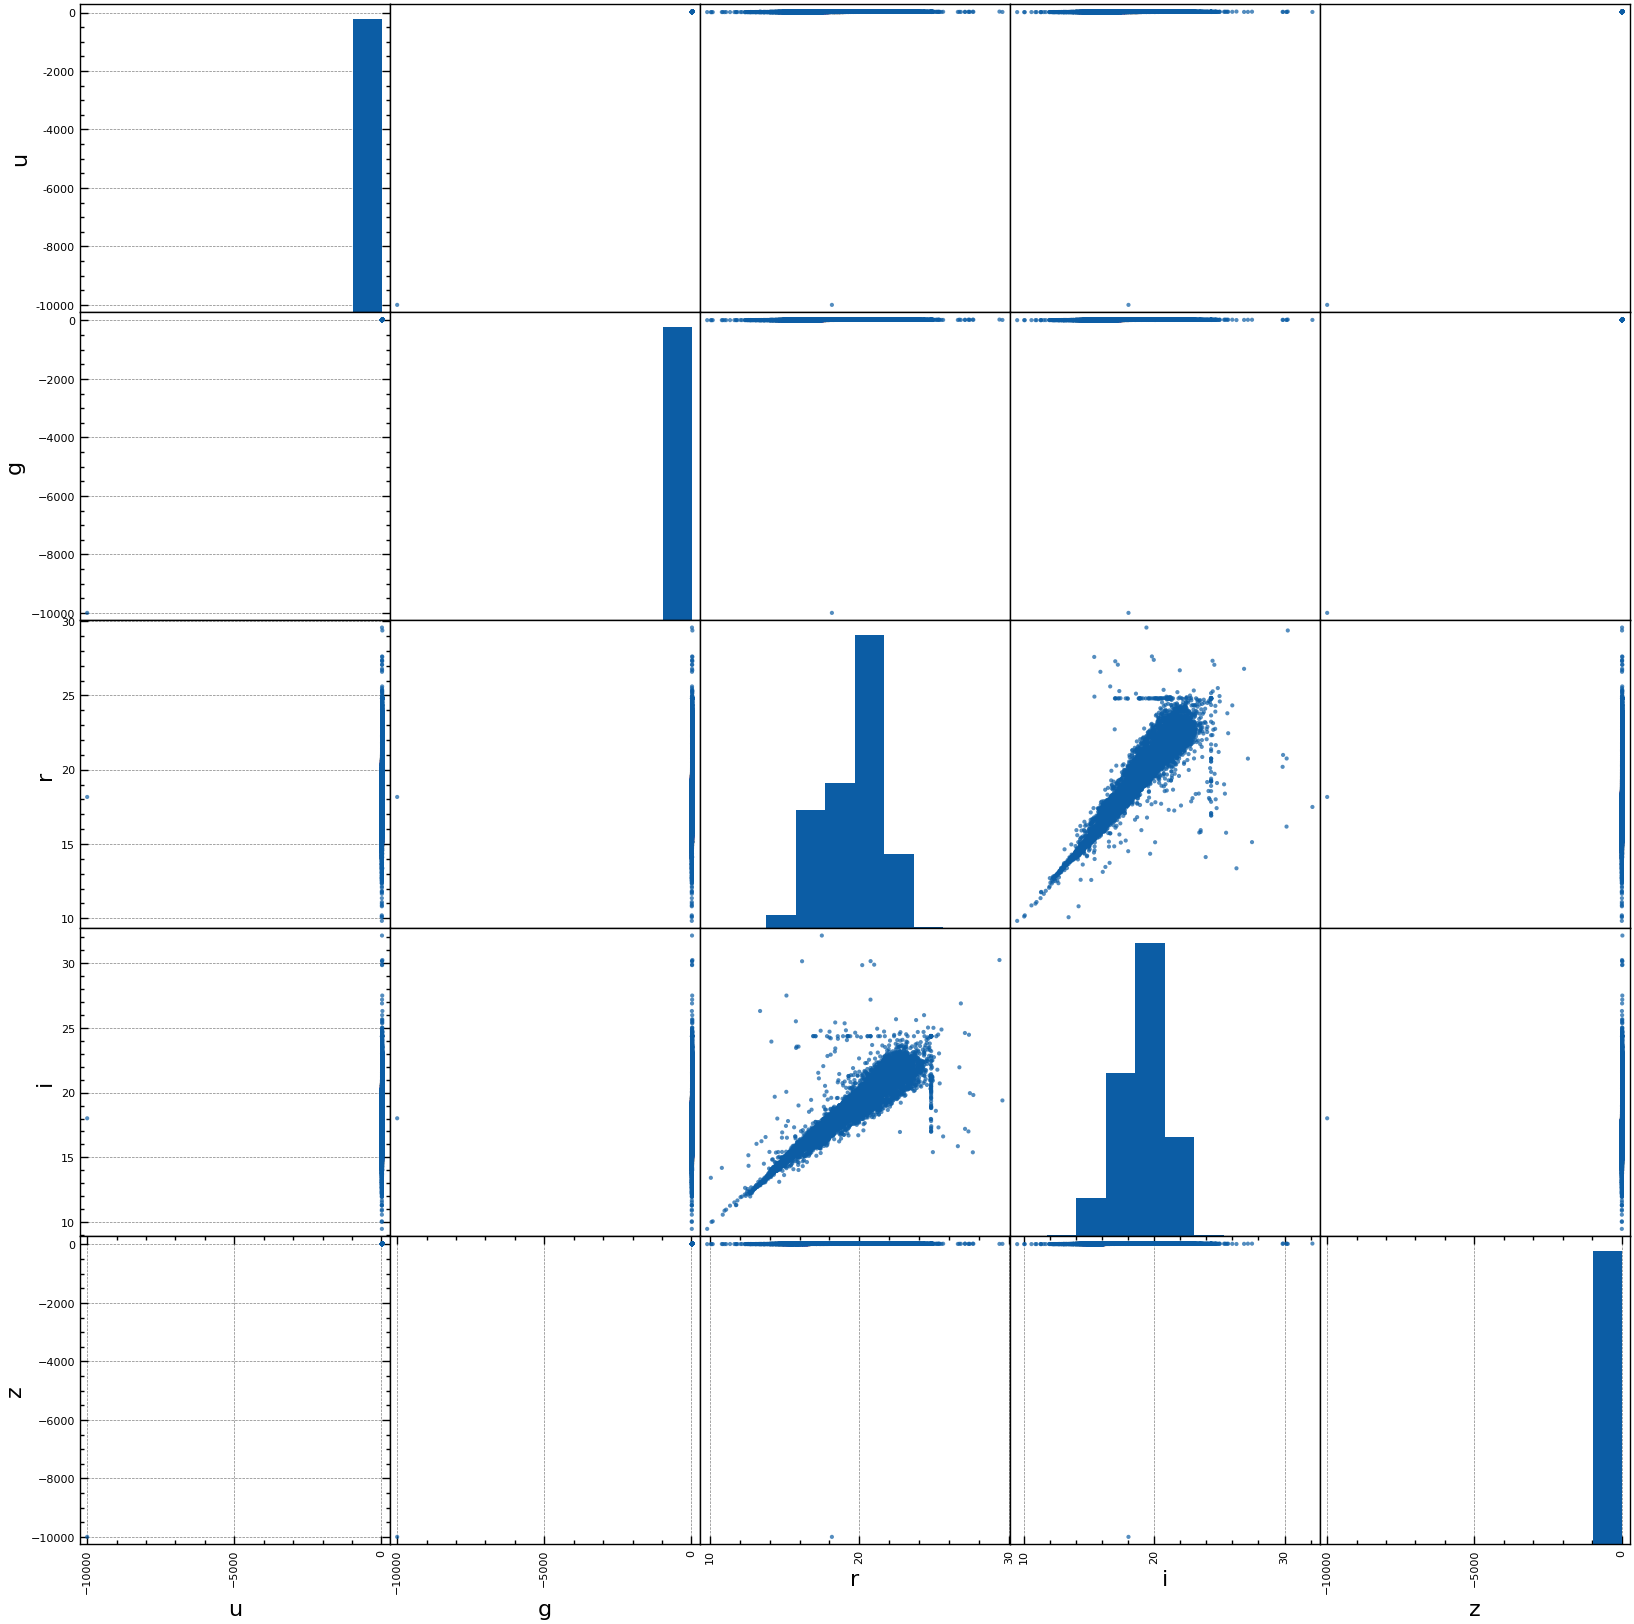

In [7]:
"""
Although (u, g), (u,z), (g,z), (r,i) are significantly correlated features as can be seen from the above cor_matrix,
their scattter plots except (r,i) don't behave in the way they should. This suggests that there may be an outlier in 
u, g, and z.
"""
scatter_matrix(spectral[["u", "g", "r", "i", "z"]], figsize=(20,20), alpha=0.7)

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'delta'}>, <Axes: title={'center': 'u'}>],
       [<Axes: title={'center': 'g'}>, <Axes: title={'center': 'r'}>,
        <Axes: title={'center': 'i'}>],
       [<Axes: title={'center': 'z'}>,
        <Axes: title={'center': 'redshift'}>, <Axes: >]], dtype=object)

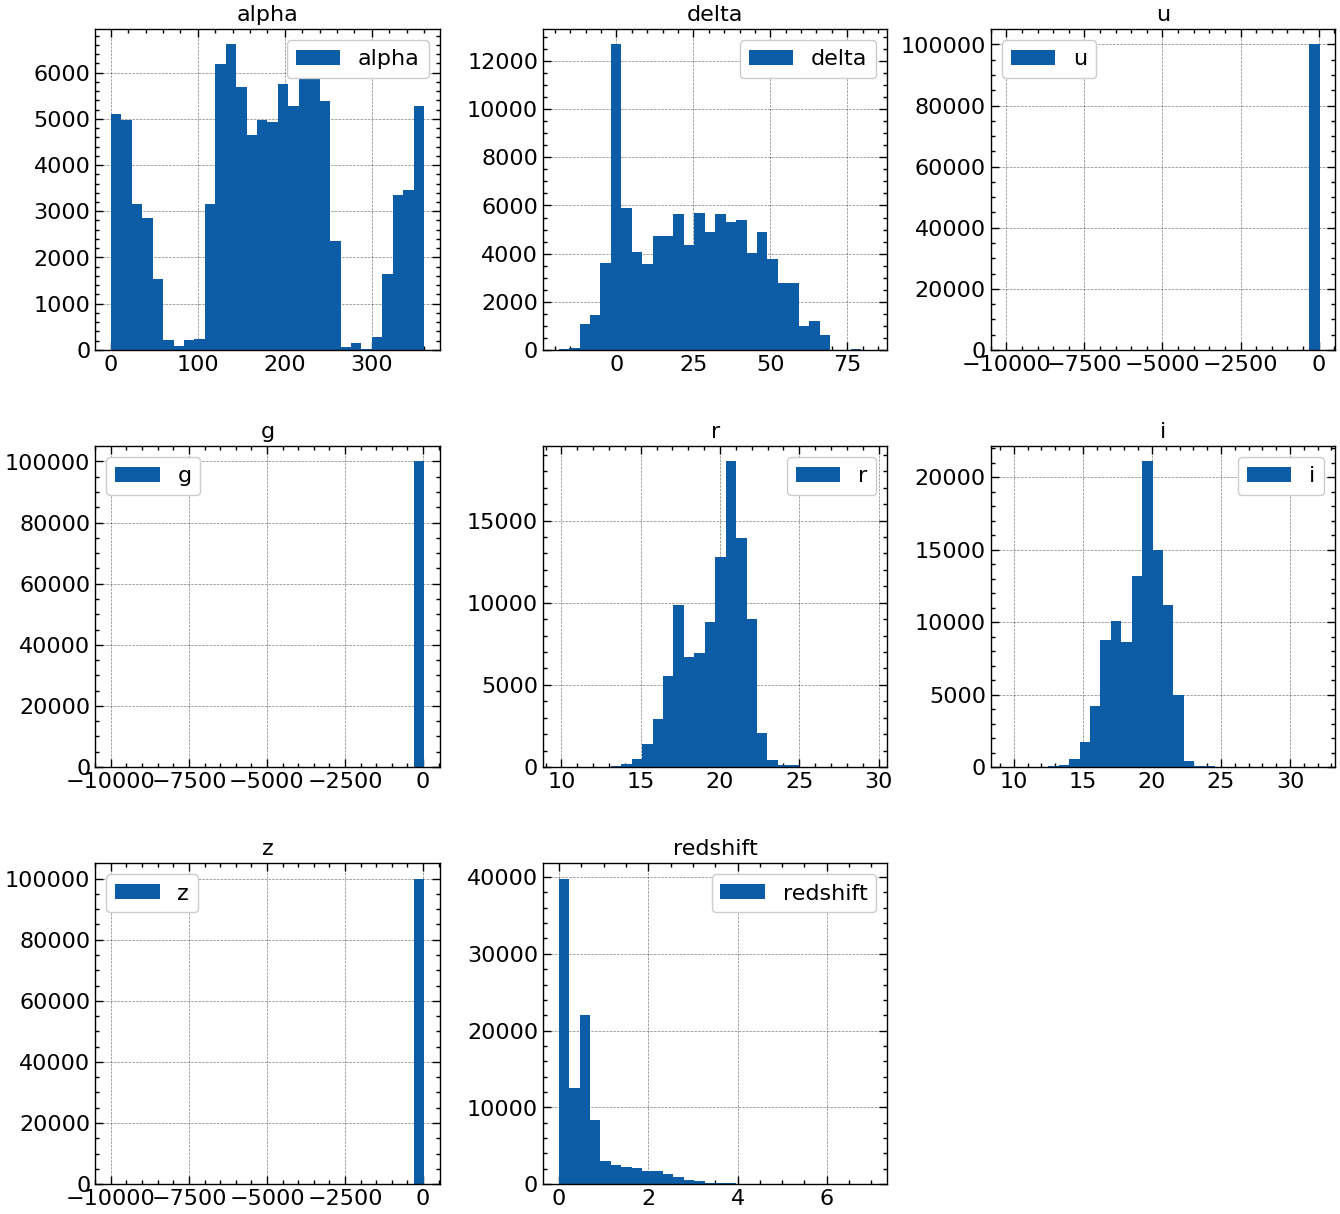

In [8]:
# Looking for possible outliers in all features
spectral.hist(bins=30, figsize=(16, 15), legend=True)


 class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64 

            u       g       z class
79543 -9999.0 -9999.0 -9999.0  STAR


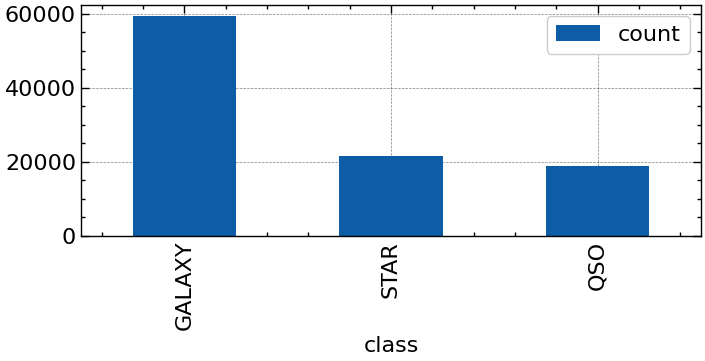

In [9]:
""" 
Categorical Label/Target - class 
Since there is only one such instance corresponding to index=79543 in spectral dataframe 
where all u, g, z have their minimum values, we conclude it is indeed an outlier
"""
print("\n", spectral["class"].value_counts(),"\n")
spectral["class"].value_counts().plot.bar(figsize=(8,3), legend=True)

print(spectral.loc[spectral["u"] == spectral["u"].min(),["u","g","z","class"]])
spectral.drop(79543, inplace=True)
spectral.to_csv("pre_processable_dataset.csv", index=False)

alpha      delta         u         g         r         i  \
0      135.689107  32.494632  23.87882  22.27530  20.39501  19.16573   
1      144.826101  31.274185  24.77759  22.83188  22.58444  21.16812   
2      142.188790  35.582444  25.26307  22.66389  20.60976  19.34857   
3      338.741038  -0.402828  22.13682  23.77656  21.61162  20.50454   
4      345.282593  21.183866  19.43718  17.58028  16.49747  15.97711   
...           ...        ...       ...       ...       ...       ...   
99994   39.620709  -2.594074  22.16759  22.97586  21.90404  21.30548   
99995   29.493819  19.798874  22.69118  22.38628  20.45003  19.75759   
99996  224.587407  15.700707  21.16916  19.26997  18.20428  17.69034   
99997  212.268621  46.660365  25.35039  21.63757  19.91386  19.07254   
99998  196.896053  49.464643  22.62171  21.79745  20.60115  20.00959   

              z  redshift   class  
0      18.79371  0.634794  GALAXY  
1      21.61427  0.779136  GALAXY  
2      18.94827  0.644195  GALAXY  
3      19.25010  0.932346  GALAXY  
4      15.54461  0.116123  GALAXY  
...         ...       ...     ...  
99994  20.73569  0.000000  GALAXY  
99995  19.41526  0.404895  GALAXY  
99996  17.35221  0.143366  GALAXY  
99997  18.62482  0.455040  GALAXY  
99998  19.28075  0.542944  GALAXY  

[99999 rows x 9 columns]

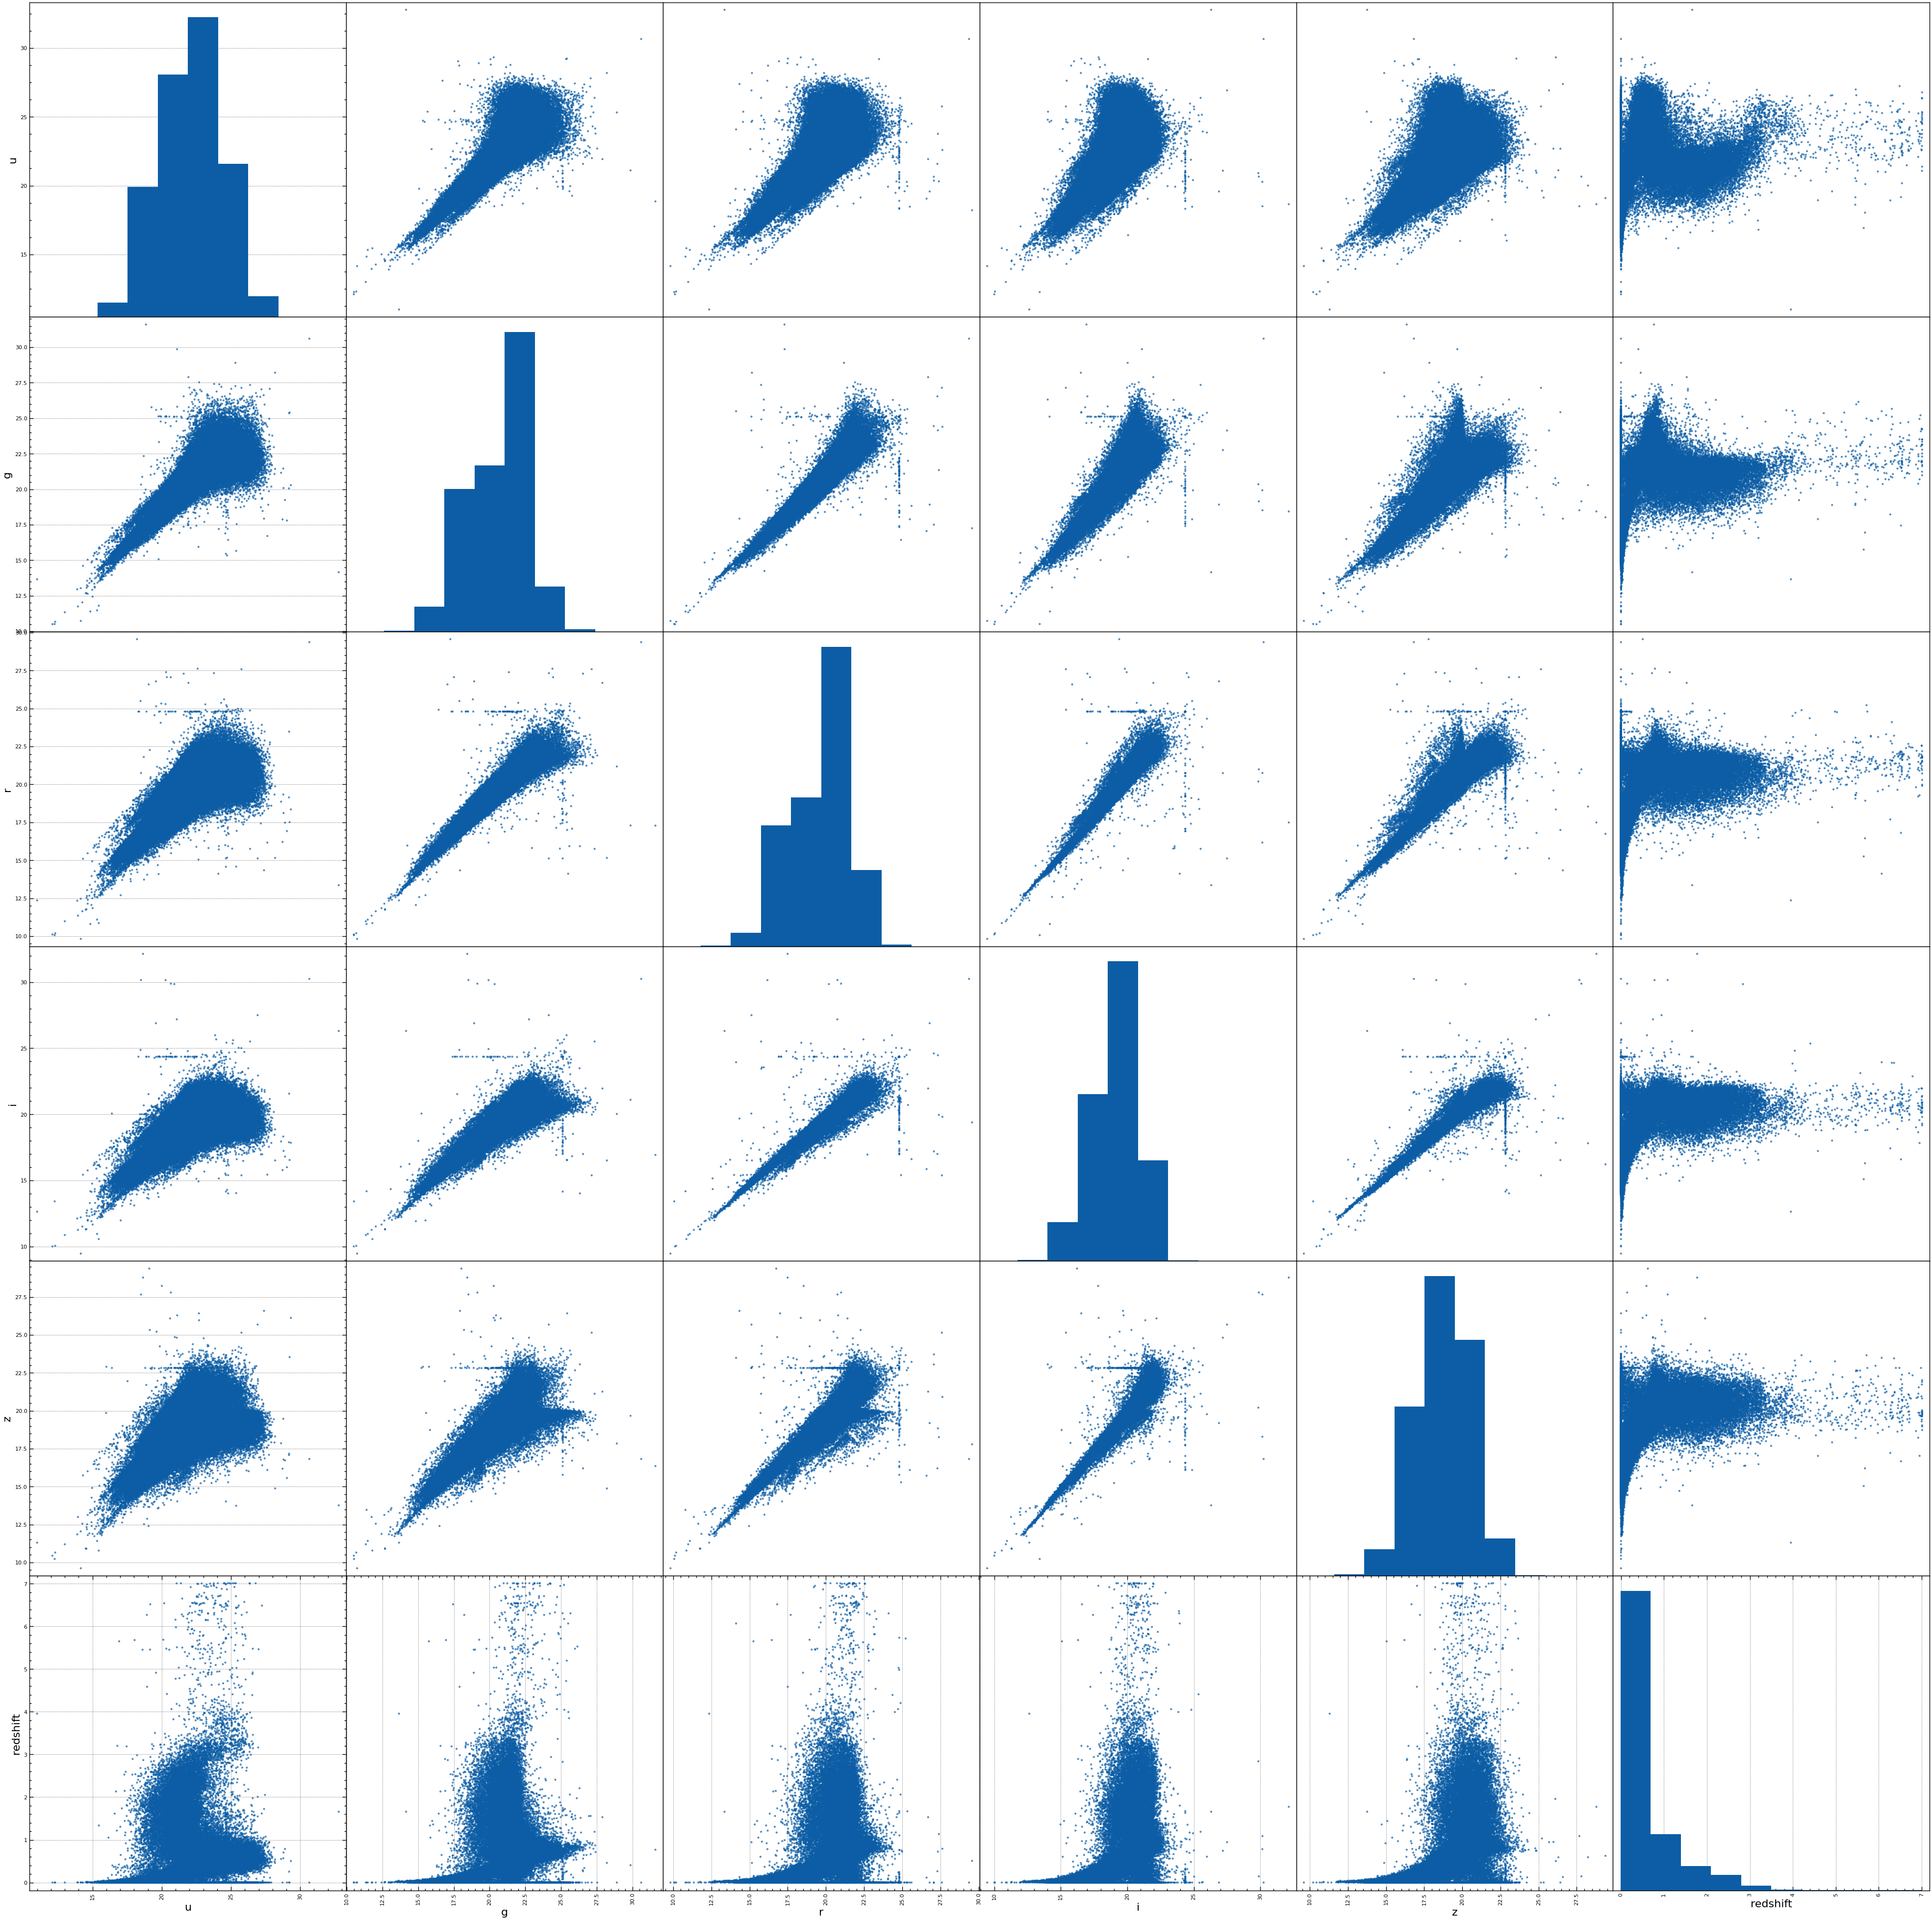

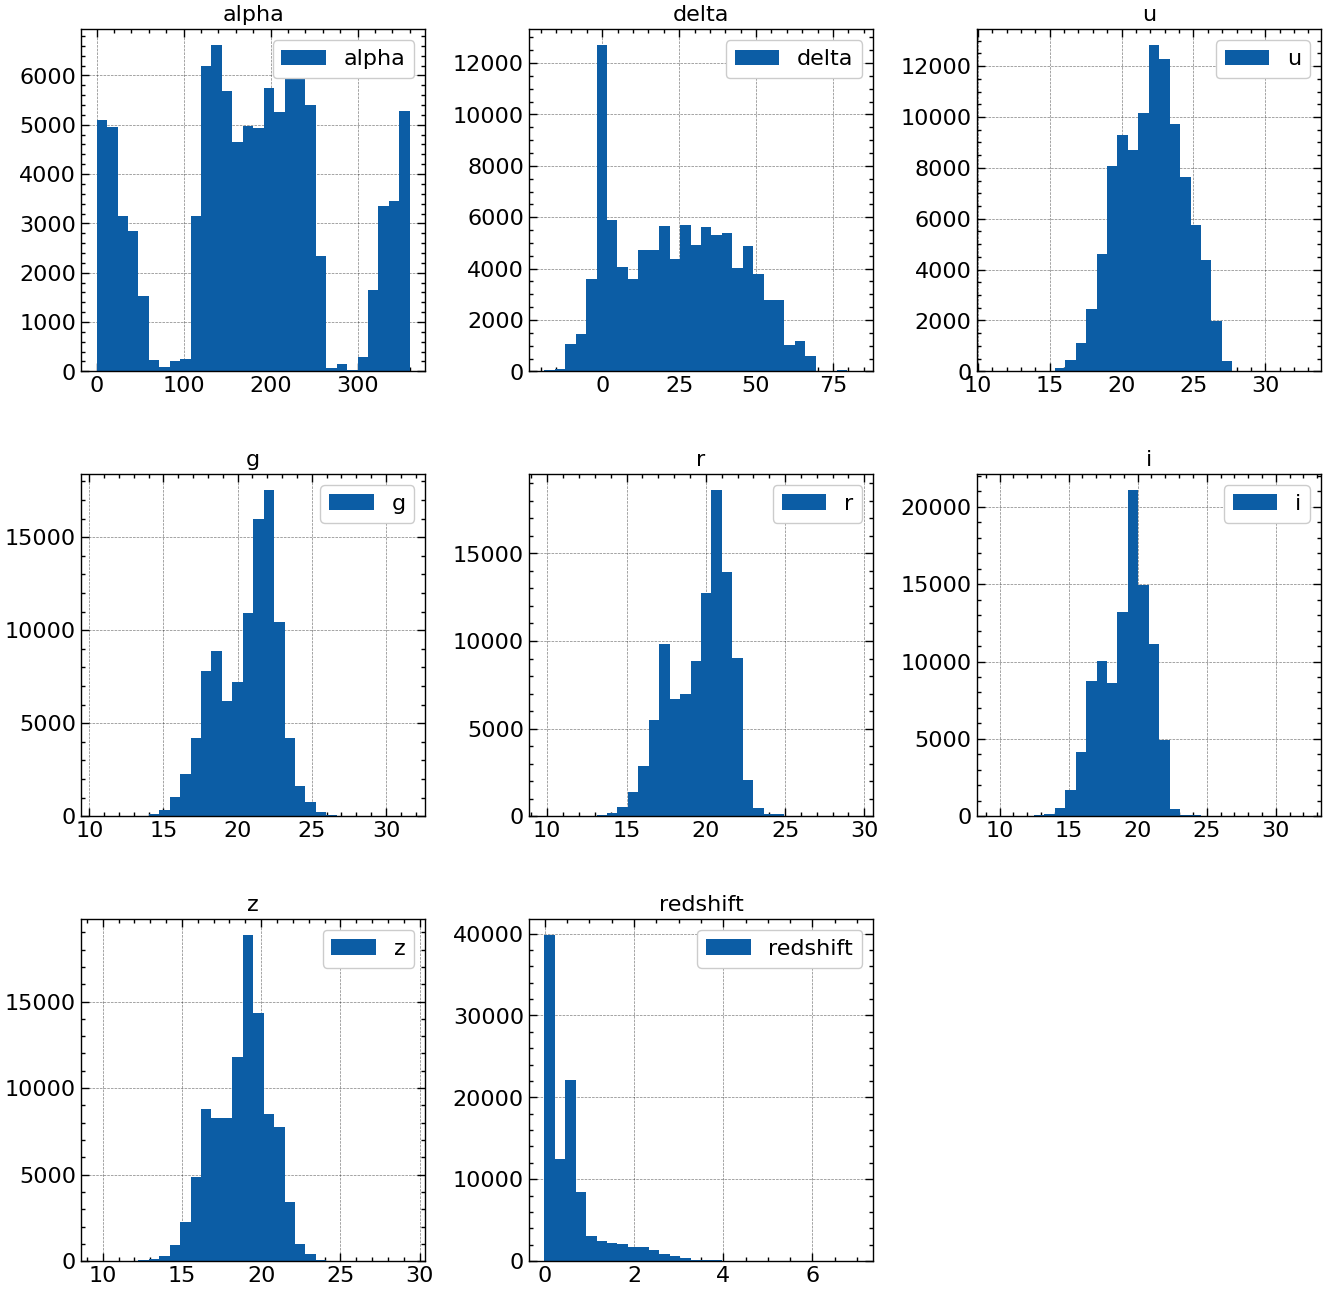

In [10]:
# Opening Pre-processable Dataset - No duplicates, unwanted features, or obvious outliers
spectral = pd.read_csv("pre_processable_dataset.csv")
scatter_matrix(spectral[["u","g","r","i","z","redshift"]], figsize=(50, 50), alpha=0.7)
spectral.hist(bins=30, figsize=(16,16), legend=True)
spectral

## __Step-3: Data Preprocessing- Null Values Treatment, Outliers Removal and Features Scaling__

In [11]:
""" 
Using Isolation Forest for outliers removal since Z-Score method assumes normal distribution
Since contamination is a hyperparameter, its value must be chosen such that f1_score is closer to 1
In our spectral dataframe, there were no null values. Just to be on the safe side while using model outside this notebook,
we are using median strategy
"""
def remove_outliers_with_isolation_forest(F):
    isolation_forest = IsolationForest(contamination=0.01, random_state=42)   # Guess: 1 % outliers/contaminations
    is_inlier = isolation_forest.fit_predict(F) == 1                          # Gives an ndarray of boolean datatype
    if len(is_inlier) == 99999:
        np.save("inlier_index.npy", np.where(is_inlier==True)[0])             # Stores inlier indices  
    return F[is_inlier]                                                       # Filtered Numeric DataFrame with inliers only

pre_processor = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),                                    # Replaces null value with median
    ("outlier_remover", FunctionTransformer(remove_outliers_with_isolation_forest)),  # For programmer-defined function
    ("scaler", StandardScaler())                 # Makes mean=0 and std=1 using z-score = (x-mean(x)) / std(x)
])
features = spectral.drop(columns=["class"], axis=1)
features_pp = pre_processor.fit_transform(features)
dump(pre_processor, "pre_processor.joblib")

index = np.load("inlier_index.npy")
label = spectral["class"]
label_pp = label[index].reset_index(drop=True)                      # Resetting index of filtered class series
features_pp = pd.DataFrame(features_pp, columns=features.columns)   # Indexing filtered features of ndarry
spectral_pp = features_pp.copy()           # Creating a copy for making filtered dataframe = features_pp + label_pp
spectral_pp["class"] = label_pp
spectral_pp

alpha     delta         u         g         r         i         z  \
0     -0.435143  0.426488  0.796509  0.809222  0.394178  0.024022 -0.008576   
1     -0.340435  0.364225  1.204761  1.090962  1.615639  1.202385  1.640267   
2     -0.367771  0.584017  1.425283  1.005926  0.513985  0.131619  0.081777   
3      1.669564 -1.251822  0.005233  1.569157  1.072913  0.811882  0.258221   
4      1.737370 -0.150547 -1.221037 -1.567389 -1.780220 -1.852411 -1.907935   
...         ...       ...       ...       ...       ...       ...       ...   
98994 -1.430927 -1.363611  0.019209  1.163844  1.236051  1.283218  1.126667   
98995 -1.535895 -0.221204  0.257042  0.865400  0.424873  0.372319  0.354770   
98996  0.486320 -0.430278 -0.434312 -0.712071 -0.828008 -0.844213 -0.851248   
98997  0.358632  1.149172  1.464946  0.486404  0.125750 -0.030818 -0.107306   
98998  0.199289  1.292236  0.225486  0.567335  0.509182  0.520615  0.276138   

       redshift   class  
0      0.077160  GALAXY  
1      0.276671  GALAXY  
2      0.090154  GALAXY  
3      0.488439  GALAXY  
4     -0.639751  GALAXY  
...         ...     ...  
98994 -0.800257  GALAXY  
98995 -0.240608  GALAXY  
98996 -0.602096  GALAXY  
98997 -0.171298  GALAXY  
98998 -0.049795  GALAXY  

[98999 rows x 9 columns]

## __Step-4: Stratified Shuffling for Splitting Preprocessed Dataset__

In [12]:
""" 
random_state = 42 ensures when we run all the cells again and again, reshuffle doesn't occur after the first instance.
This prevents the model from seeing the test dataset. 
To verify: rerun all the cells multiple times and see how the x_train remains unchanged via its index.
"""
slicer = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_indices, test_indices in slicer.split(spectral_pp, spectral_pp["class"]):
    train_set = spectral_pp.iloc[train_indices]
    test_set = spectral_pp.iloc[test_indices]
    
x_train = train_set.drop(columns=["class"], axis=1)          # If inplace = True is made then next line will not run
y_train = train_set["class"]
x_test = test_set.drop(columns=["class"], axis=1)            # If inplace = True is made then next line will not run
y_test = test_set["class"]

# Stratified Shuffling: Percentage of GALAXY samples in each Training and Test sets is one and the same
print(f"In Training Dataset: \n\n{y_train.value_counts()}")
print(f"Percentage of Galaxy = {(y_train.value_counts().iloc[0] * 100)/len(y_train.index)}")
print(f"\n\nIn Test Dataset: \n\n{y_test.value_counts()}")
print(f"Percentage of Galaxy = {(y_test.value_counts().iloc[0] * 100)/len(y_test.index)}\n\n")
print(f"Shapes of Training and Test Datasets: {x_train.shape}, {x_test.shape}")
x_train

In Training Dataset: 

class
GALAXY    47168
STAR      16921
QSO       15110
Name: count, dtype: int64
Percentage of Galaxy = 59.556307529135466


In Test Dataset: 

class
GALAXY    11792
STAR       4231
QSO        3777
Name: count, dtype: int64
Percentage of Galaxy = 59.55555555555556


Shapes of Training and Test Datasets: (79199, 8), (19800, 8)


alpha     delta         u         g         r         i         z  \
4176   0.548756  0.682117 -0.934138 -0.435707  0.026334  0.310646  0.498354   
54575 -0.746615  0.224117 -1.350943 -1.472613 -1.415092 -1.316590 -1.194233   
78941  0.101367  0.726948  1.390665  1.827870  1.246707  0.995023  0.584206   
7619   0.436168  0.041763 -0.604309 -0.989305 -1.240556 -1.246714 -1.283059   
47629 -0.118934 -0.946406 -0.975255 -1.069330 -1.066768 -1.038746 -0.998258   
...         ...       ...       ...       ...       ...       ...       ...   
56769  0.426377 -0.326506  1.521353  0.390667 -0.062672 -0.141858 -0.162642   
93653 -1.685890 -0.107435  1.664896  1.774608  1.413426  1.095511  0.647299   
49534 -0.099578  0.988319  0.646979  0.705502  0.669648  0.453711  0.579816   
73674  0.415984  0.721831  0.327267  0.314920  0.709196  0.922416  0.852814   
16563  0.218670  1.108269  0.761783  0.589436  0.473438  0.301336  0.219837   

       redshift  
4176   0.248255  
54575 -0.800110  
78941  0.060949  
7619  -0.557135  
47629 -0.649137  
...         ...  
56769 -0.228594  
93653  0.325390  
49534  0.087255  
73674 -0.800341  
16563 -0.800583  

[79199 rows x 8 columns]

## __Step-5: Selecting the Most Appropriate Model__

In [13]:
""" 
Other tried model's results have been saved in tried_models.txt file and their confusion matrices have been saved in the 
folder named Training Confusion Matrix where both the former and the latter are present in the same directory this notebook is
"""
model = BaggingClassifier()

model.fit(x_train, y_train)
sample_features = x_train.iloc[10:20]
sample_true_label = y_train.iloc[10:20]
sample_predicted_label = model.predict(sample_features)
print(f"Sample True Label: \n{list(sample_true_label)}")
print(f"Sample Predicted Label: \n{list(sample_predicted_label)}")

Sample True Label: 
['STAR', 'STAR', 'GALAXY', 'GALAXY', 'STAR', 'GALAXY', 'GALAXY', 'STAR', 'GALAXY', 'GALAXY']
Sample Predicted Label: 
['STAR', 'STAR', 'GALAXY', 'GALAXY', 'STAR', 'GALAXY', 'GALAXY', 'STAR', 'GALAXY', 'GALAXY']


# __Step-6: Checking whether the Model is Overfitted or not__

In [14]:
true_label = y_train
predicted_label = model.predict(x_train)
accuracy = accuracy_score(true_label, predicted_label)
print(f"Accuracy of the model is {accuracy}")
if accuracy == 1:
    print("The Model is Overfitted")
else:
    print("The Model is not Overfitted")

Accuracy of the model is 0.9973484513693355
The Model is not Overfitted


## __Step-7: Closer the F1 Score to 1, Better is the Model__
1. __Confusion Matrix:__ A confusion matrix is a table that summarizes the performance of a classification model by comparing the predicted classes to the true classes.
2. __Precision:__ It indicates how many of the predicted positive instances were actually positive.
3. __Recall:__ It indicates how many of the actual positive instances were correctly predicted by the model.
4. __F1 Score__ It is the harmonic mean of precision and recall.

![For Binary Classification](https://www.ris-ai.com/static/images/models/confusion-matrix-recall-formula-.jpg)


Precision = 0.9759001215822176, Recall = 0.9760224245255622, F1 Score = 0.9758418399891079


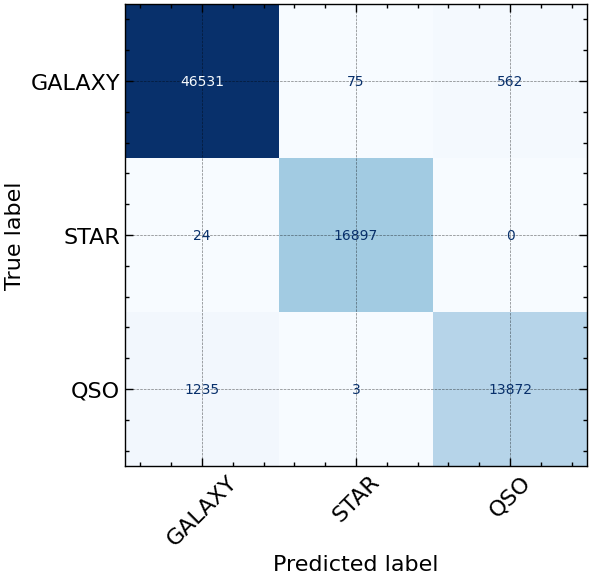

In [15]:
"""
By default, evaluation metrics like precision_score, recall_score, f1_score use binary averaging. 
Hence for multiclass label, average parameter needs to be defined in the metric(say precision).. 
1. average="weighted":  Used for the datasets having imbalanced classes, it calculates the precision for each class and 
                        weights it by the number of true instances for each class.
2. average="macro":  It computes the precision for each class independently and then averages these precision scores, 
                     treating each class equally.
3. average="micro": Used for the datasets having balanced classes, it aggregates the contributions of all classes by summing
                    the true positives and false positives across all classes before calculating the precision score.
"""
cross_val_predicted_label = cross_val_predict(model, x_train, y_train, cv=3)
con_mat = confusion_matrix(true_label, cross_val_predicted_label, labels=["GALAXY","STAR","QSO"])
precision = precision_score(true_label, cross_val_predicted_label, average="weighted")
recall = recall_score(true_label, cross_val_predicted_label, average="weighted")
f1 = f1_score(true_label, cross_val_predicted_label, average="weighted")

print(f"Precision = {precision}, Recall = {recall}, F1 Score = {f1}")
dump(model, "Model.joblib")
matrix = ConfusionMatrixDisplay(confusion_matrix=con_mat, display_labels=["GALAXY","STAR","QSO",])
matrix.plot(colorbar=False, cmap='Blues', xticks_rotation=45)
plt.savefig("training_confusion_matrix_Bagging_Classifier.png", dpi=500)
plt.show()

## __Step-8: Testing the Model__

Accuracy = 0.9767676767676767, 

Precision = 0.9766407602762947, Recall = 0.9767676767676767, F1 Score = 0.9766385805424034





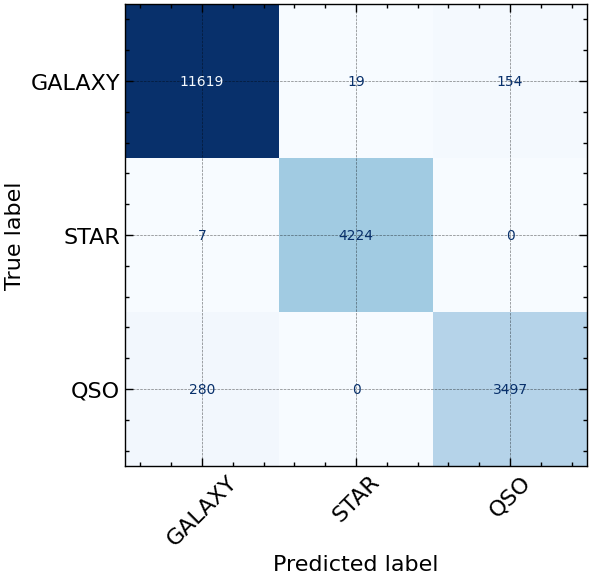

In [16]:
final_predicted_label = model.predict(x_test)
final_true_label = y_test

final_con_mat = confusion_matrix(final_true_label, final_predicted_label, labels=["GALAXY","STAR","QSO"])
final_accuracy = accuracy_score(final_true_label, final_predicted_label)
final_precision = precision_score(final_true_label, final_predicted_label, average="weighted")
final_recall = recall_score(final_true_label, final_predicted_label, average="weighted")
final_f1 = f1_score(final_true_label, final_predicted_label, average="weighted")

print(f"Accuracy = {final_accuracy}, \n\nPrecision = {final_precision}, Recall = {final_recall}, F1 Score = {final_f1}\n\n\n")
final_matrix = ConfusionMatrixDisplay(confusion_matrix=final_con_mat, display_labels=["GALAXY","STAR","QSO",])
final_matrix.plot(colorbar=False, cmap='Blues', xticks_rotation=45)
plt.savefig("test_confusion_matrix_Bagging_Classifier.png", dpi=500)
plt.show()